# Tests to validate lost light calculations

**Scott Prahl**

**April 2024**

In [1]:
import subprocess
from io import StringIO

import numpy as np
import matplotlib.pyplot as plt
from mcmlpy import MCMLV2

%config InlineBackend.figure_format='retina'

def calc_areas(n, dr):
    """Returns areas of each annulus."""
    areas = (2 * np.linspace(0, n-1, int(n)) + 1) * np.pi * dr**2
    return areas

# generate the binary executable from https://github.com/scottprahl/iad
# using 'make executable' and updating this path appropriately
mc_lost_path = "mc_lost"

## Index matched sample

### Absorbing-only case

Checking transmission in absorbing only medium.  This verifies that launching photons is correct.

In [2]:
mus = 0  # per mm
mua = 1  # per mm
g = 0
n_sample = 1.0
n_slide = 1.0
t_sample = 1
t_slide = 0
a = mus/(mua+mus)
b = (mua+mus)*t_sample
beam_radius = 5 # mm

In [3]:
beam_diameter = beam_radius * 2
port_diameter = np.array([11],dtype=float)
iad_r_lost = np.zeros_like(port_diameter)
iad_t_lost = np.zeros_like(port_diameter)

for i, P in enumerate(port_diameter):
    print('running port diameter = %d' % P)
    command = [
        mc_lost_path,
        "-a", str(a),
        "-b", str(b),
        "-B", str(beam_diameter),
        "-n", str(n_sample),
        "-N", str(n_slide),
        "-P", str(P),
        "-t", str(t_sample),
        "-T", str(t_slide),
        "-p", "1000000",
        "-m",
        "-C"
    ]
    
    result = subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    x = result.stdout.split()
    iad_mc_ur1 = float(x[0])
    iad_mc_ut1 = float(x[1])
    iad_ur1 = float(x[4])
    iad_ut1 = float(x[5])
    iad_r_lost[i] = float(x[8])
    iad_t_lost[i] = float(x[9])

buffer=StringIO(result.stderr)
ndr = np.genfromtxt(buffer, max_rows=1)
dr = np.genfromtxt(buffer, max_rows=1)
iad_r, iad_rt, iad_tt = np.genfromtxt(buffer, skip_header=8, max_rows=ndr).T
buffer.close()

running port diameter = 11


Here we see that the transmitted light is exactly what is expected from exponential attenuation.  Both the magnitude and the beam radius match exactly.

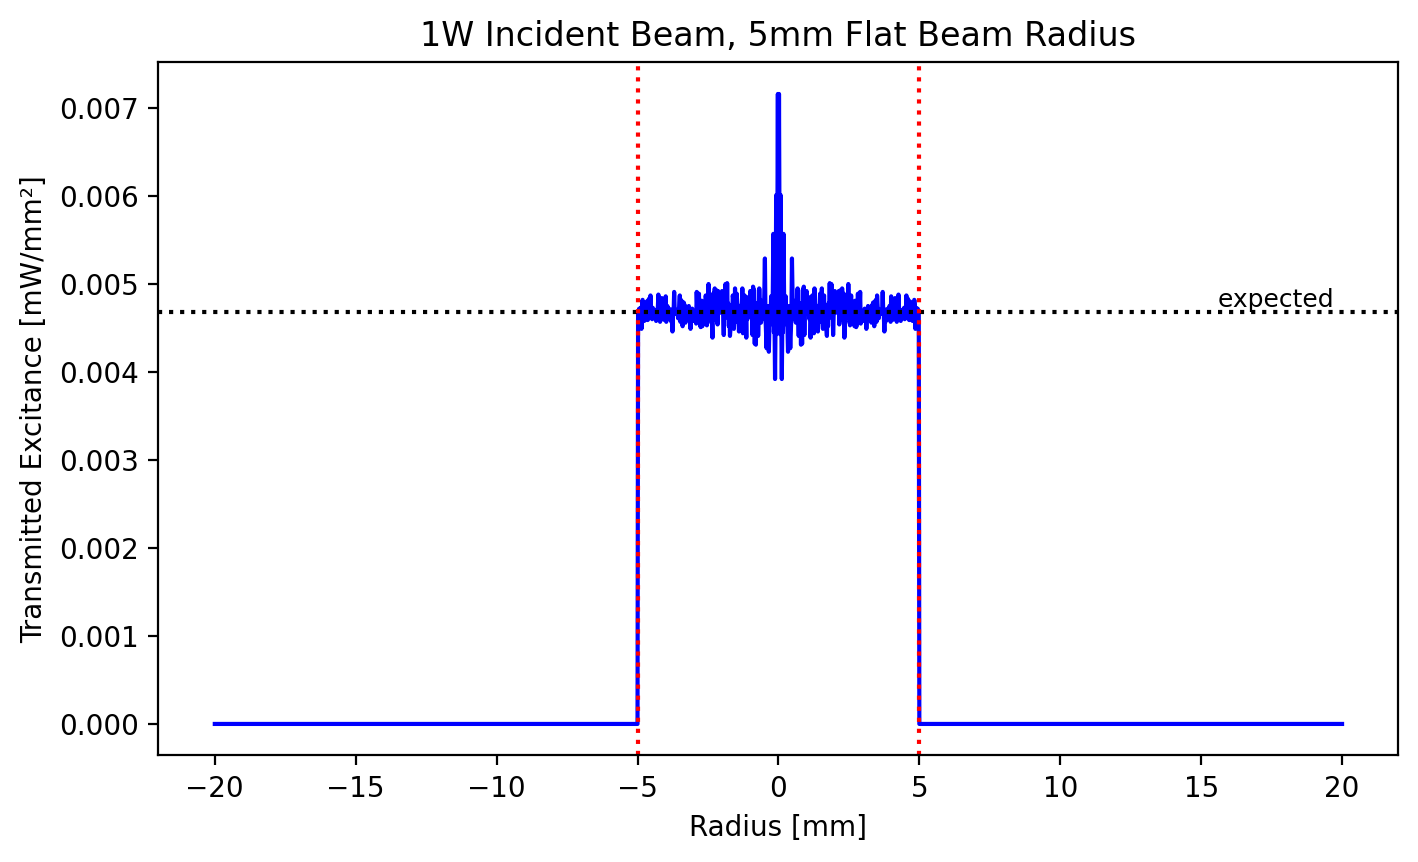

In [4]:
plt.plot( iad_r, iad_tt, color='blue')
plt.plot(-iad_r, iad_tt, color='blue')
trans = np.exp(-b)/(beam_radius**2*np.pi)
plt.axhline(trans, color='black', ls=':')
plt.axvline(beam_radius, color='red', ls=':')
plt.axvline(-beam_radius, color='red', ls=':')

plt.text(iad_r[-1], trans, 'expected ', color='black', ha='right', va='bottom', fontsize=9)
plt.xlabel('Radius [mm]')
plt.ylabel('Transmitted Excitance [mW/mm²]')
plt.title('1W Incident Beam, 5mm Flat Beam Radius')
plt.show()

Finally, the cumulative sum of the transmitted excitance matches the total transmission

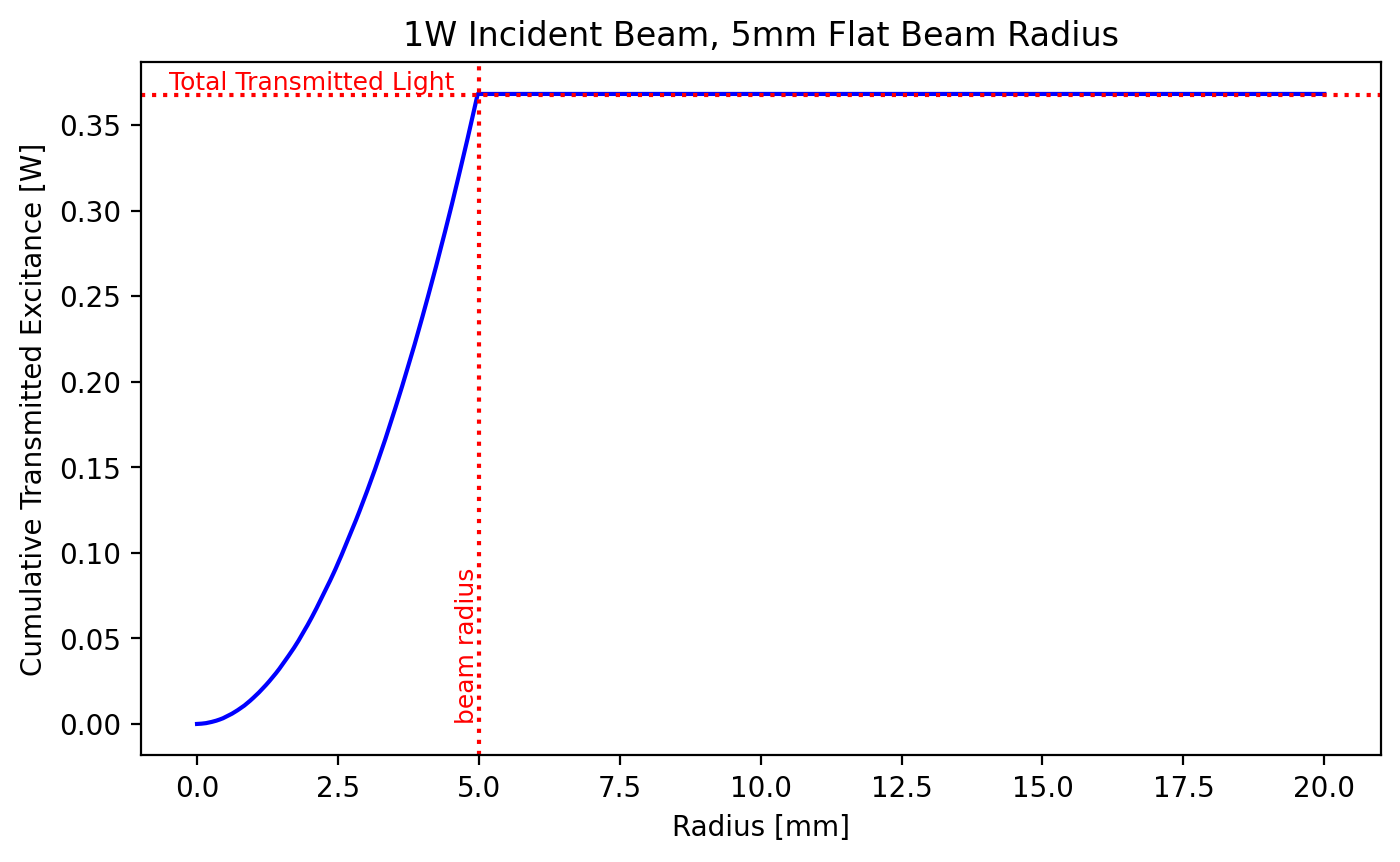

In [5]:
areas = calc_areas(ndr, dr)
iad_cumtt = np.cumsum(iad_tt*areas)

plt.figure(figsize=(8,4.5))
plt.plot(iad_r, iad_cumtt, color='blue')
plt.axhline(iad_ut1, color='red', linestyle=':')
plt.text(iad_r[0]-0.5, iad_ut1, 'Total Transmitted Light', ha='left', va='bottom', color='red', fontsize=9)

plt.axvline(beam_radius, color='red', ls=':')
plt.xlabel('Radius [mm]')
plt.text(beam_radius, 0, 'beam radius', ha='right', va='bottom', color='red', rotation=90, fontsize=9)

plt.ylabel('Cumulative Transmitted Excitance [W]')
plt.title('1W Incident Beam, 5mm Flat Beam Radius')
plt.show()

### Comparing Impulse Responses

In [6]:
mus = 0.99  # per mm
mua = 0.01  # per mm
g = 0
n_sample = 1.0
n_slide = 1.0
t_sample = 10
t_slide = 0
a = mus/(mua+mus)
b = (mua+mus)*t_sample
beam_radius = 0 # mm

beam_diameter = beam_radius * 2
port_diameter = np.array([3],dtype=float)
iad_r_lost = np.zeros_like(port_diameter)
iad_t_lost = np.zeros_like(port_diameter)

for i, P in enumerate(port_diameter):
    print('running port diameter = %d' % P)
    command = [
        mc_lost_path,
        "-a", str(a),
        "-b", str(b),
        "-B", str(beam_diameter),
        "-n", str(n_sample),
        "-N", str(n_slide),
        "-P", str(P),
        "-t", str(t_sample),
        "-T", str(t_slide),
        "-p", "1000000",
        "-m",
        "-C"
    ]

    result = subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    x = result.stdout.split()
    iad_mc_ur1 = float(x[0])
    iad_mc_ut1 = float(x[1])
    iad_ur1 = float(x[4])
    iad_ut1 = float(x[5])
    iad_r_lost[i] = float(x[8])
    iad_t_lost[i] = float(x[9])

buffer=StringIO(result.stderr)
ndr = np.genfromtxt(buffer, max_rows=1)
dr = np.genfromtxt(buffer, max_rows=1)
iad_r, iad_rt, iad_tt = np.genfromtxt(buffer, skip_header=8, max_rows=ndr).T
buffer.close()

running port diameter = 3


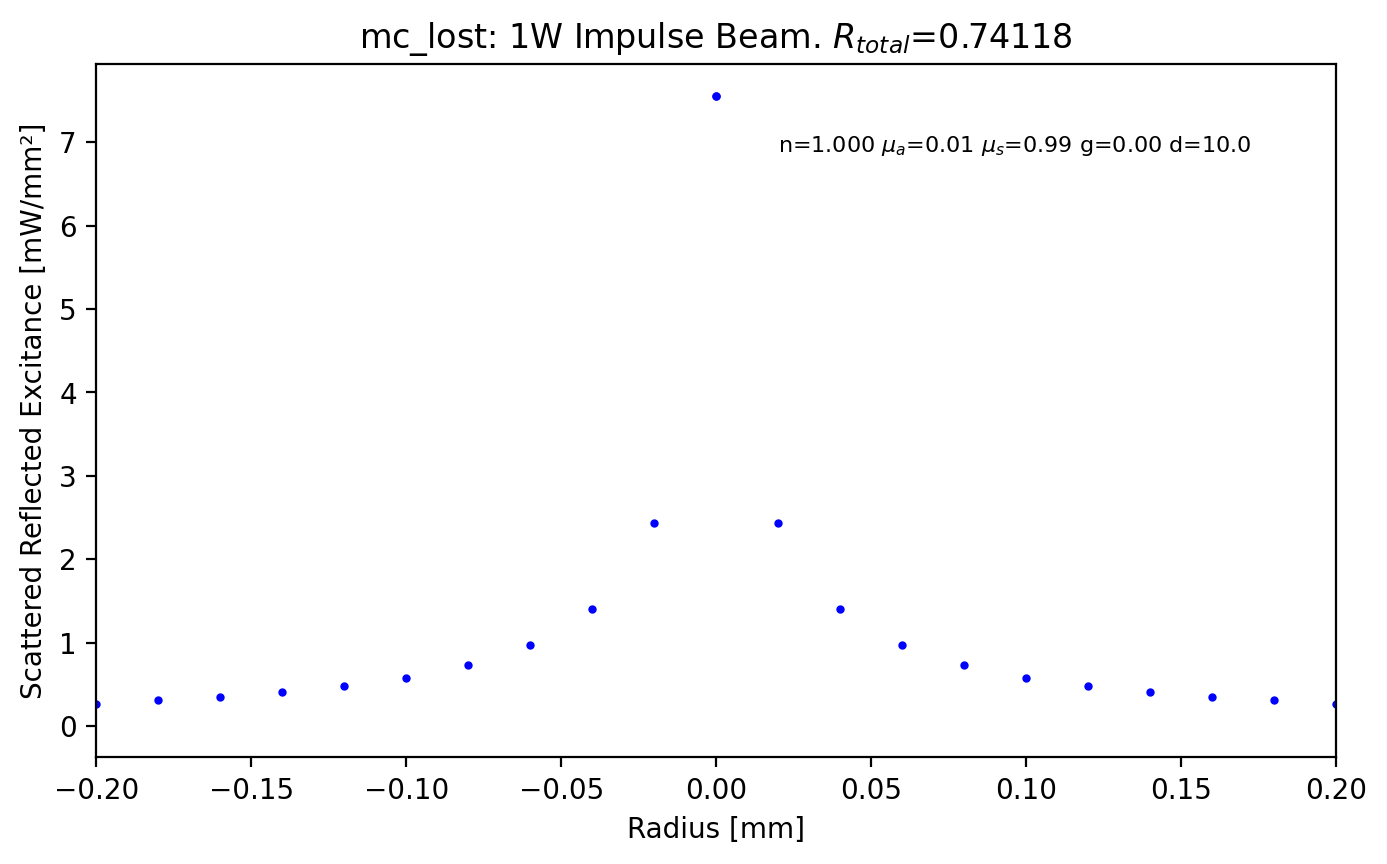

In [7]:
s = ''
s += r'n=%.3f ' % n_sample
s += r'$\mu_a$=%.2f ' % mua
s += r'$\mu_s$=%.2f ' % mus
s += r'g=%.2f ' % g
s += r'd=%.1f' % t_sample

plt.plot(iad_r, iad_rt, 'ob', markersize=2)
plt.plot(-iad_r, iad_rt, 'ob', markersize=2)
plt.xlabel('Radius [mm]')
plt.ylabel('Scattered Reflected Excitance [mW/mm²]')
plt.title('mc_lost: 1W Impulse Beam. $R_{total}$=%7.5f'%iad_mc_ur1)
#plt.axvspan(-beam_radius, beam_radius, color='cyan')
plt.xlim(-0.2,0.2)

plt.text(0.55, 0.9, s, ha='left', va='top', transform=plt.gca().transAxes, fontsize=8)
plt.show()

photons       = 0

R_unscattered =  0.00000
R_scattered   =  0.74038
R_total       =  0.74038
T_unscattered =  0.00005
T_scattered   =  0.08535
T_total       =  0.08539
Absorbed      =  0.17423
Total         =  1.00000

r_bins = 1001, dr = 0.020 mm
z_bins =    1, dz = 0.200 mm
t_bins =    1, dt = 0.100 ps

layer 1: air
    n=1.000 µa=0.00mm⁻¹ µs=0.00mm⁻¹ g=0.00 d=infinite
layer 2: polyurethane
    n=1.000 µa=0.01mm⁻¹ µs=0.99mm⁻¹ g=0.00 d=10.00mm
layer 3: air
    n=1.000 µa=0.00mm⁻¹ µs=0.00mm⁻¹ g=0.00 d=infinite



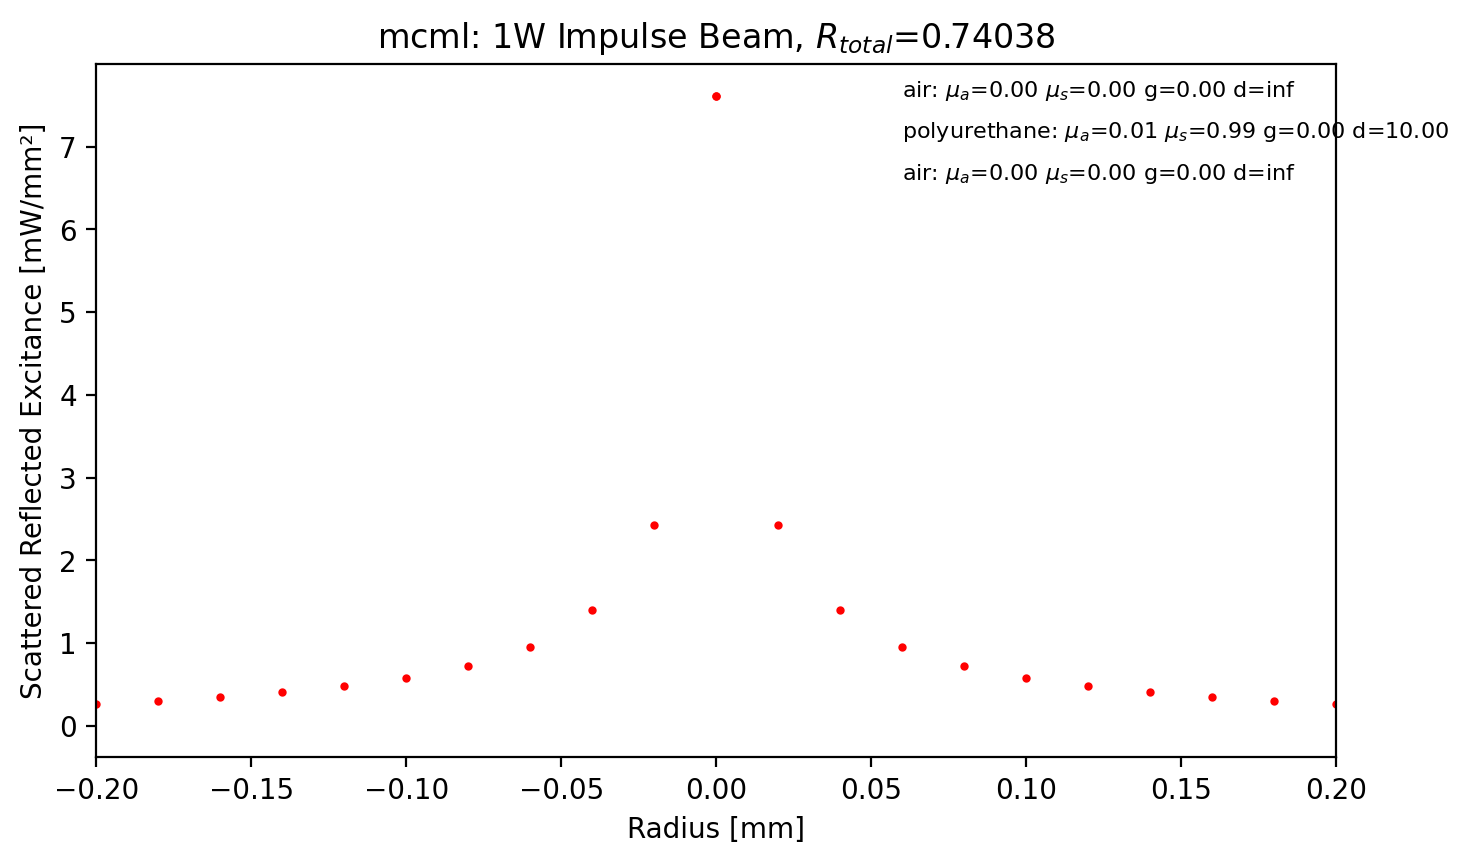

In [8]:
path = '../tests/mc-lost-v2-1.mco'
mcml = MCMLV2()
mcml.init_from_file(path)
print(mcml)

plt.plot(mcml.r,mcml.Rdr, 'or', markersize=2)
plt.plot(-mcml.r,mcml.Rdr, 'or', markersize=2)
plt.xlabel('Radius [mm]')
plt.ylabel('Scattered Reflected Excitance [mW/mm²]')
plt.title('mcml: 1W Impulse Beam, $R_{total}$=%7.5f'%mcml.Rt)
plt.xlim(-0.2,0.2)
mcml.add_plot_text()
plt.show()

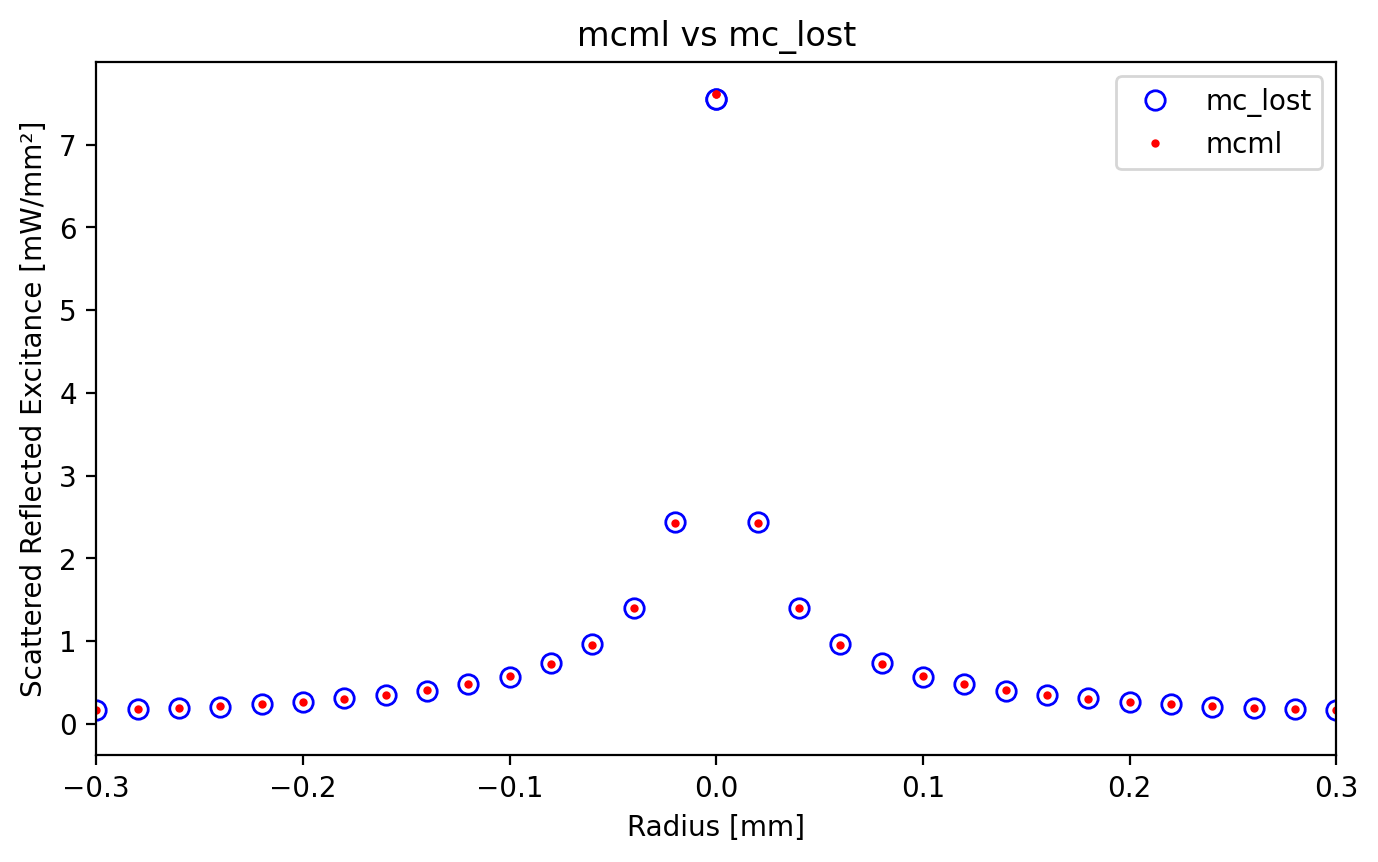

In [9]:
plt.plot(iad_r, iad_rt, 'ob', markersize=7, markerfacecolor='white', markeredgecolor='blue', label='mc_lost')
plt.plot(-iad_r, iad_rt, 'ob', markersize=7, markerfacecolor='white', markeredgecolor='blue')
plt.plot(mcml.r, mcml.Rdr, 'or', markersize=2, label='mcml')
plt.plot(-mcml.r, mcml.Rdr, 'or', markersize=2)
plt.xlabel('Radius [mm]')
plt.ylabel('Scattered Reflected Excitance [mW/mm²]')
plt.title('mcml vs mc_lost')
plt.xlim(-0.3,0.3)
plt.legend()
plt.show()

### Comparing 3mm beams

In [10]:
mus = 0.99  # per mm
mua = 0.01  # per mm
g = 0
n_sample = 1.0
n_slide = 1.0
t_sample = 10
t_slide = 0
a = mus/(mua+mus)
b = (mua+mus)*t_sample
beam_radius = 1.5 # mm

beam_diameter = beam_radius * 2
port_diameter = np.array([3],dtype=float)
iad_r_lost = np.zeros_like(port_diameter)
iad_t_lost = np.zeros_like(port_diameter)

for i, P in enumerate(port_diameter):
    print('running port diameter = %d' % P)
    command = [
        mc_lost_path,
        "-a", str(a),
        "-b", str(b),
        "-B", str(beam_diameter),
        "-n", str(n_sample),
        "-N", str(n_slide),
        "-P", str(P),
        "-t", str(t_sample),
        "-T", str(t_slide),
        "-p", "1000000",
        "-m",
        "-C"
    ]
    result = subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    x = result.stdout.split()
    iad_mc_ur1 = float(x[0])
    iad_mc_ut1 = float(x[1])
    iad_ur1 = float(x[4])
    iad_ut1 = float(x[5])
    iad_r_lost[i] = float(x[8])
    iad_t_lost[i] = float(x[9])

buffer=StringIO(result.stderr)
ndr = np.genfromtxt(buffer, max_rows=1)
dr = np.genfromtxt(buffer, max_rows=1)
iad_r_3mm, iad_rt_3mm, iad_tt_3mm = np.genfromtxt(buffer, skip_header=8, max_rows=ndr).T
buffer.close()

running port diameter = 3


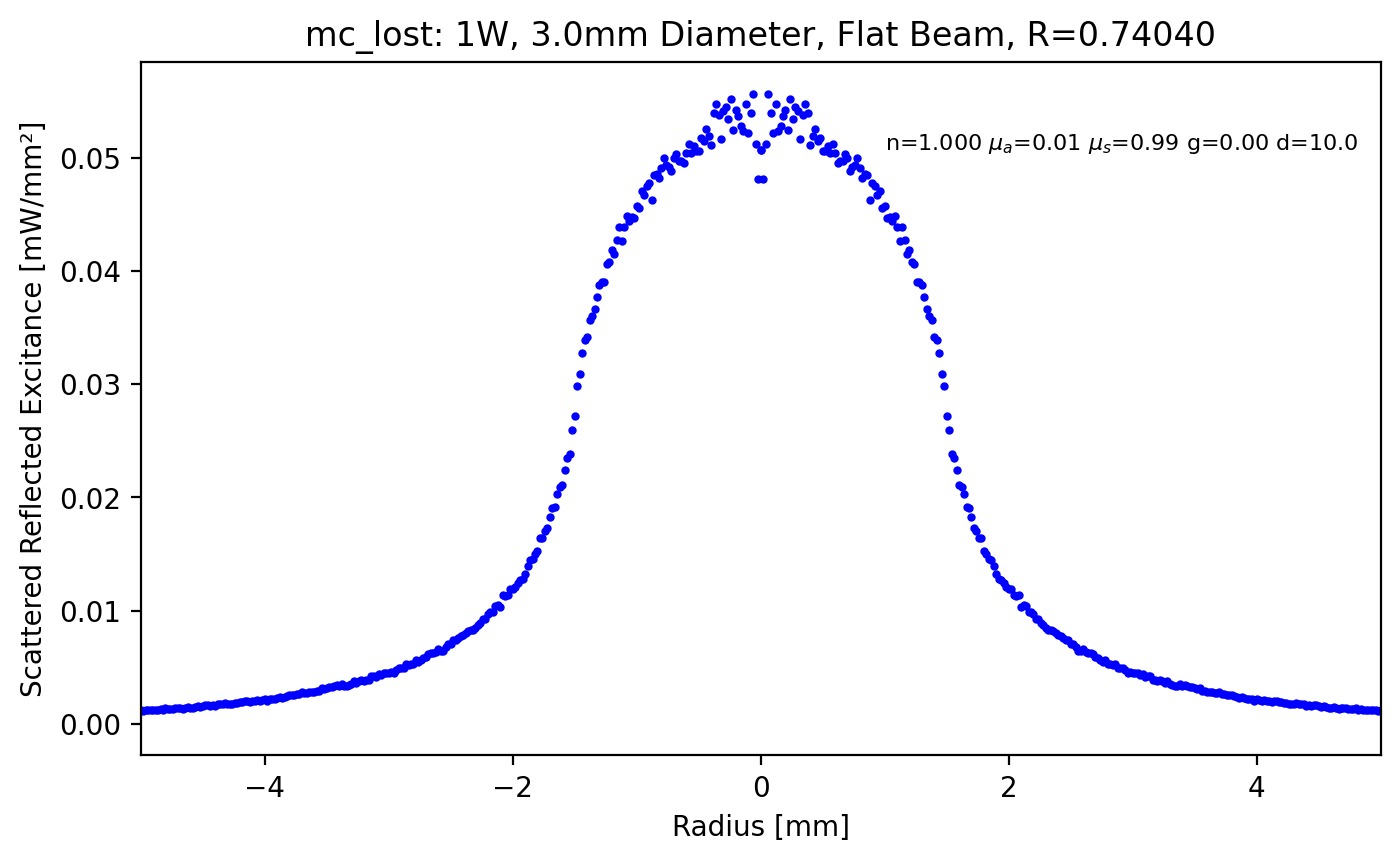

In [11]:
s = ''
s += r'n=%.3f ' % n_sample
s += r'$\mu_a$=%.2f ' % mua
s += r'$\mu_s$=%.2f ' % mus
s += r'g=%.2f ' % g
s += r'd=%.1f' % t_sample

plt.plot(iad_r_3mm, iad_rt_3mm, 'ob', markersize=2)
plt.plot(-iad_r_3mm, iad_rt_3mm, 'ob', markersize=2)
plt.xlabel('Radius [mm]')
plt.ylabel('Scattered Reflected Excitance [mW/mm²]')
plt.title('mc_lost: 1W, %.1fmm Diameter, Flat Beam, R=%.5f'%(beam_diameter,iad_mc_ur1))
#plt.axvspan(-beam_radius, beam_radius, color='cyan')
plt.xlim(-5,5)

plt.text(0.6, 0.9, s, ha='left', va='top', transform=plt.gca().transAxes, fontsize=8)
plt.show()

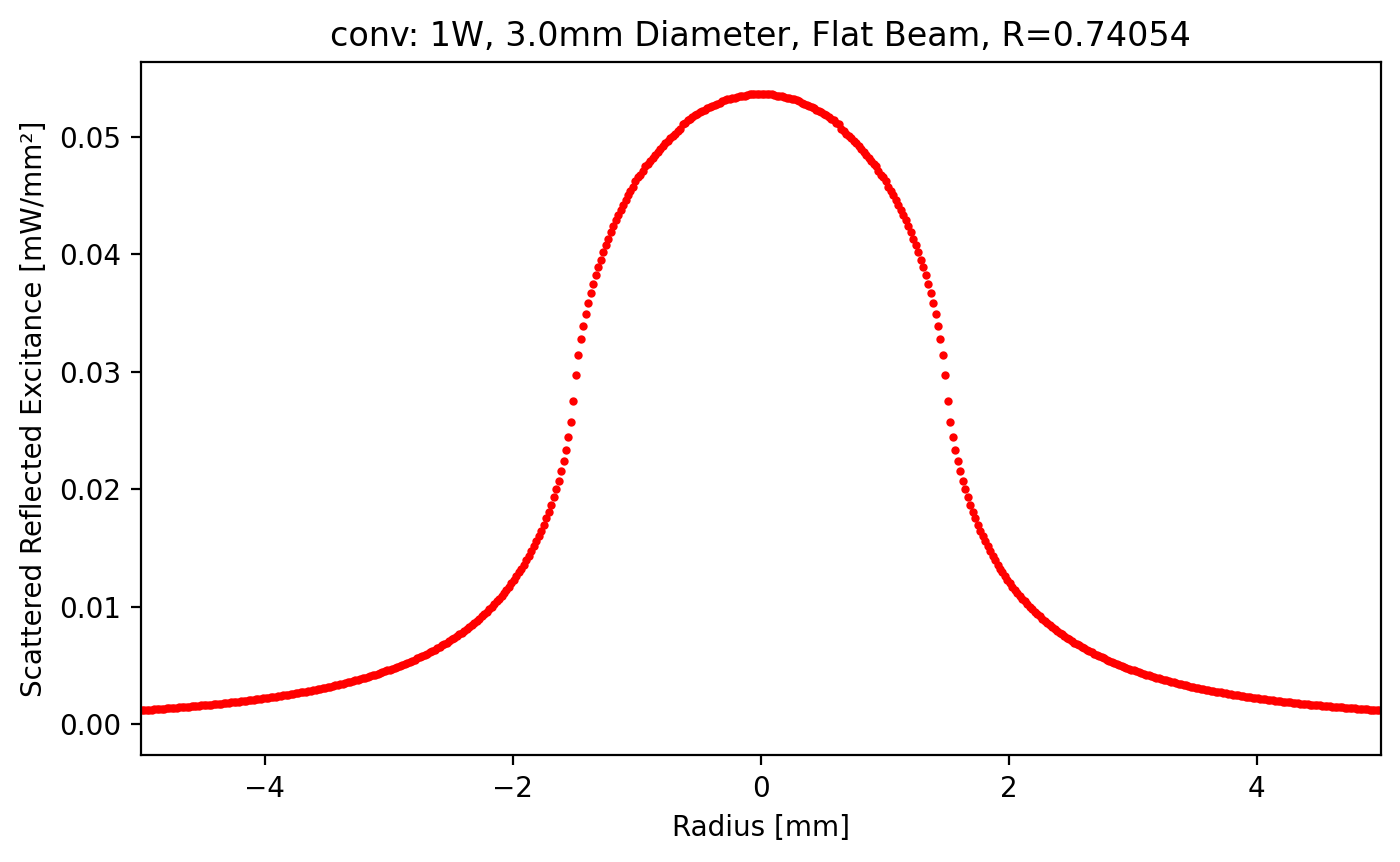

In [12]:
fn = '../tests/mc-lost-v2-1.Rdrc'
mcml_r_3mm, mcml_rd_3mm = np.genfromtxt(fn, skip_header=4).T
mcml_r_3mm *= 10
mcml_rd_3mm /= 100
plt.plot(mcml_r_3mm, mcml_rd_3mm, 'or', markersize=2)
plt.plot(-mcml_r_3mm, mcml_rd_3mm, 'or', markersize=2)

plt.xlabel('Radius [mm]')
plt.ylabel('Scattered Reflected Excitance [mW/mm²]')
plt.title('conv: 1W, %.1fmm Diameter, Flat Beam, R=%.5f'%(beam_diameter,0.74054))
#plt.axvspan(-beam_radius, beam_radius, color='cyan')
plt.xlim(-5,5)
plt.show()

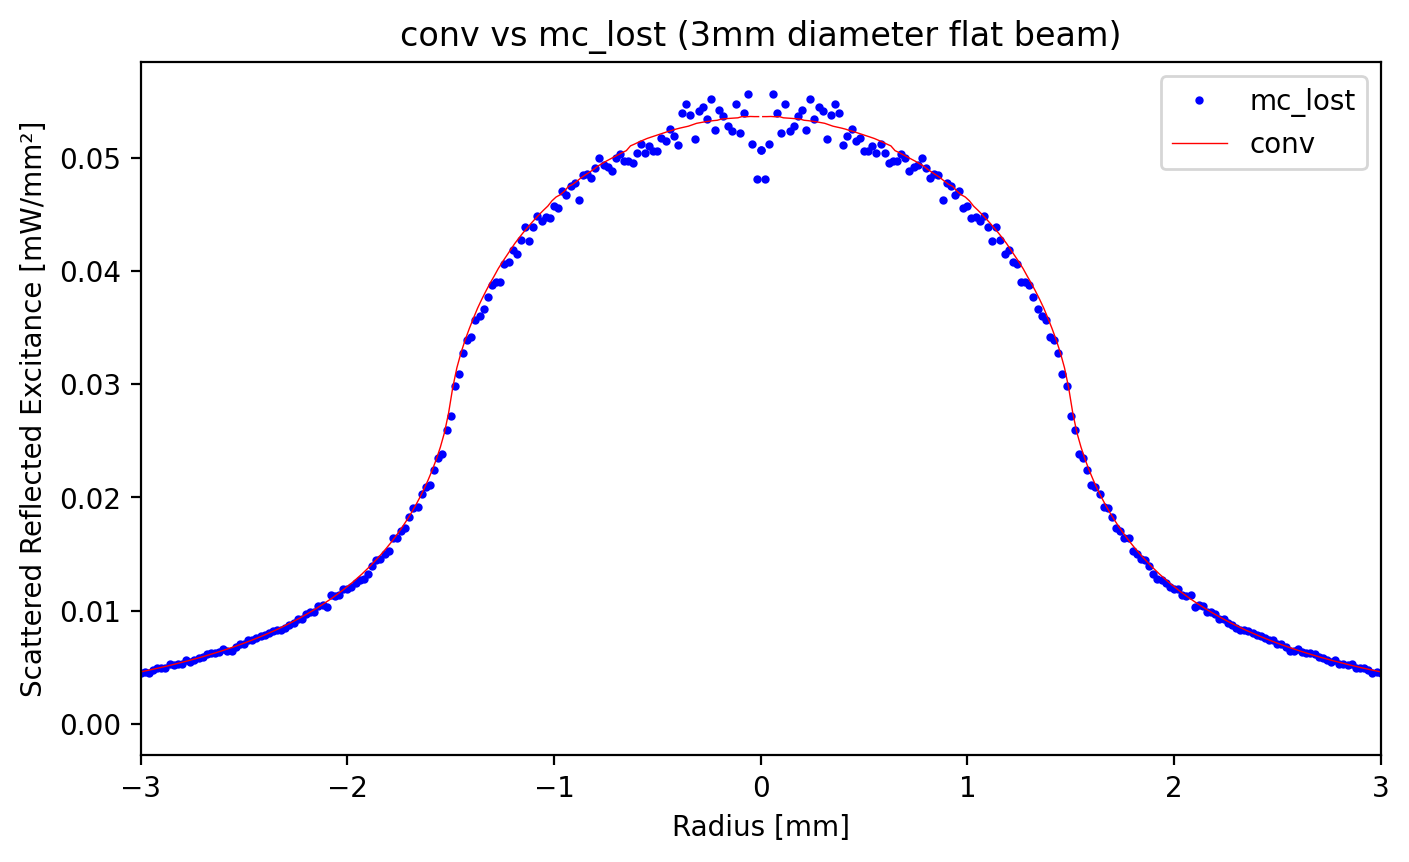

In [13]:
plt.plot(iad_r_3mm, iad_rt_3mm, 'ob', markersize=2, label='mc_lost')
plt.plot(-iad_r_3mm, iad_rt_3mm, 'ob', markersize=2)
plt.plot(mcml_r_3mm, mcml_rd_3mm, 'r',  lw=0.5, label='conv')
plt.plot(-mcml_r_3mm, mcml_rd_3mm, 'r', lw=0.5, )
plt.xlabel('Radius [mm]')
plt.ylabel('Scattered Reflected Excitance [mW/mm²]')
plt.title('conv vs mc_lost (3mm diameter flat beam)')
plt.xlim(-3,3)
plt.legend()
plt.show()

## Index mismatched sample

### First compare impulse responses

In [14]:
mus = 0.99  # per mm
mua = 0.01  # per mm
g = 0
n_sample = 1.4
n_slide = 1.0
t_sample = 10
t_slide = 0
a = mus/(mua+mus)
b = (mua+mus)*t_sample
beam_radius = 0 # mm

In [15]:
beam_diameter = beam_radius * 2
port_diameter = np.array([3],dtype=float)
iad_r_lost = np.zeros_like(port_diameter)
iad_t_lost = np.zeros_like(port_diameter)

for i, P in enumerate(port_diameter):
    print('running port diameter = %d' % P)
    command = [
        mc_lost_path,
        "-a", str(a),
        "-b", str(b),
        "-B", str(beam_diameter),
        "-n", str(n_sample),
        "-N", str(n_slide),
        "-P", str(P),
        "-t", str(t_sample),
        "-T", str(t_slide),
        "-p", "1000000",
        "-m",
        "-C"
    ]

    result = subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    x = result.stdout.split()
    iad_mc_ur1 = float(x[0])
    iad_mc_ut1 = float(x[1])
    iad_ur1 = float(x[4])
    iad_ut1 = float(x[5])
    iad_r_lost[i] = float(x[8])
    iad_t_lost[i] = float(x[9])

buffer=StringIO(result.stderr)
ndr = np.genfromtxt(buffer, max_rows=1)
dr = np.genfromtxt(buffer, max_rows=1)
iad_r, iad_rt, iad_tt = np.genfromtxt(buffer, skip_header=8, max_rows=ndr).T
buffer.close()

# remove specularly reflected light to compare with mcml
rsp = ((n_sample-1)/(n_sample+1))**2
iad_rt[0]-=rsp/(np.pi*dr**2)


running port diameter = 3


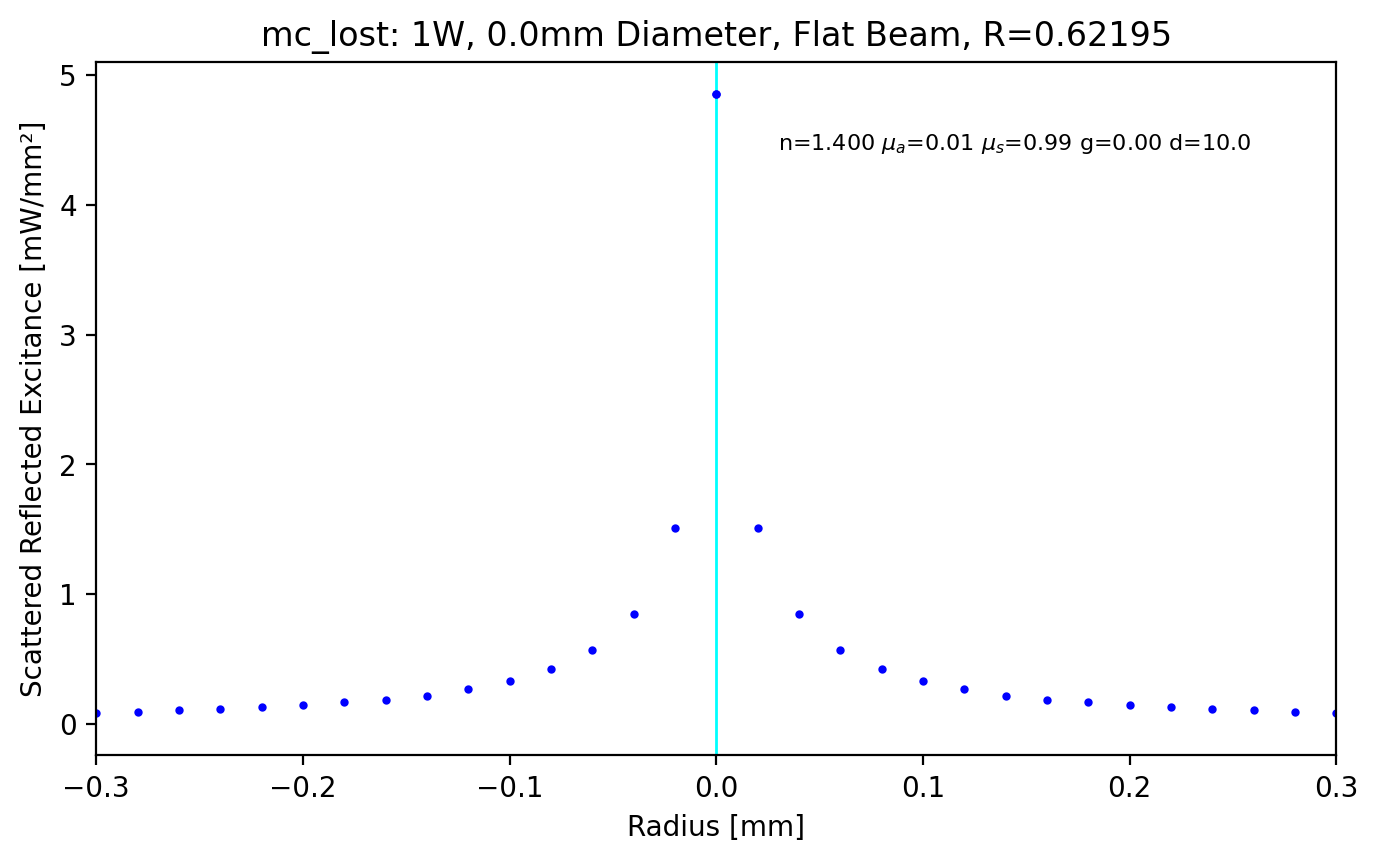

In [16]:
plt.plot(iad_r, iad_rt, 'ob', markersize=2)
plt.plot(-iad_r, iad_rt, 'ob', markersize=2)
plt.xlabel('Radius [mm]')
plt.ylabel('Scattered Reflected Excitance [mW/mm²]')
plt.title('mc_lost: 1W, %.1fmm Diameter, Flat Beam, R=%.5f'%(beam_diameter,iad_mc_ur1))
plt.axvspan(-beam_radius, beam_radius, color='cyan')
plt.xlim(-0.3,0.3)

s = ''
s += r'n=%.3f ' % n_sample
s += r'$\mu_a$=%.2f ' % mua
s += r'$\mu_s$=%.2f ' % mus
s += r'g=%.2f ' % g
s += r'd=%.1f' % t_sample
plt.text(0.55, 0.9, s, ha='left', va='top', transform=plt.gca().transAxes, fontsize=8)

plt.show()

photons       = 0

R_unscattered =  0.02778
R_scattered   =  0.59344
R_total       =  0.62122
T_unscattered =  0.00004
T_scattered   =  0.10332
T_total       =  0.10336
Absorbed      =  0.27542
Total         =  1.00000

r_bins = 1001, dr = 0.020 mm
z_bins =    1, dz = 0.200 mm
t_bins =    1, dt = 0.100 ps

layer 1: air
    n=1.000 µa=0.00mm⁻¹ µs=0.00mm⁻¹ g=0.00 d=infinite
layer 2: polyurethane
    n=1.400 µa=0.01mm⁻¹ µs=0.99mm⁻¹ g=0.00 d=10.00mm
layer 3: air
    n=1.000 µa=0.00mm⁻¹ µs=0.00mm⁻¹ g=0.00 d=infinite



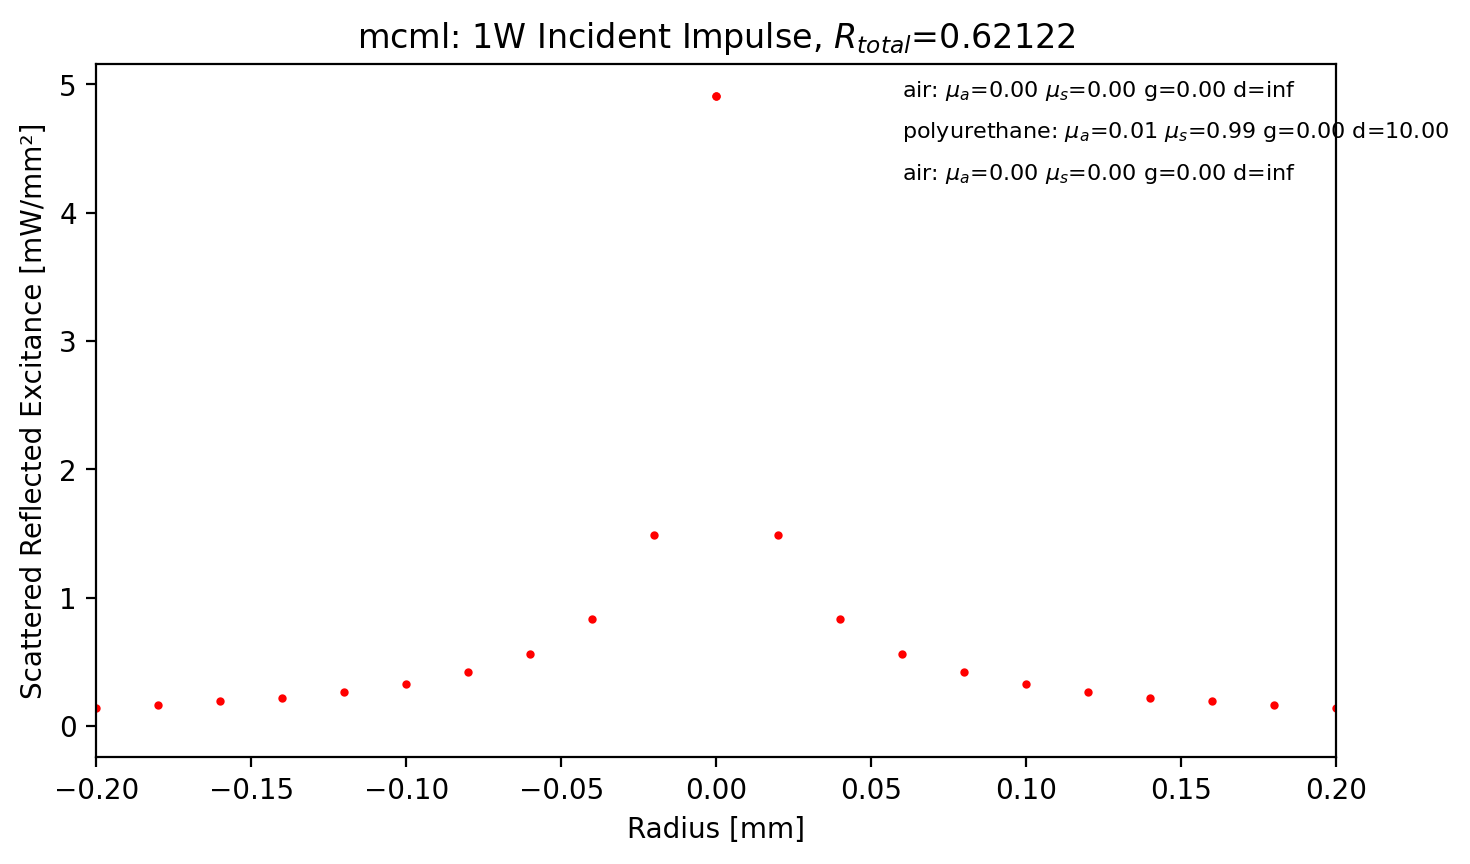

In [17]:
path = '../tests/mc-lost-v2-2.mco'
mcml = MCMLV2()
mcml.init_from_file(path)
print(mcml)

plt.plot(mcml.r,mcml.Rdr, 'or', markersize=2)
plt.plot(-mcml.r,mcml.Rdr, 'or', markersize=2)
plt.xlabel('Radius [mm]')
plt.ylabel('Scattered Reflected Excitance [mW/mm²]')
plt.title('mcml: 1W Incident Impulse, $R_{total}$=%7.5f'%mcml.Rt)
plt.xlim(-0.2,0.2)
mcml.add_plot_text()
plt.show()

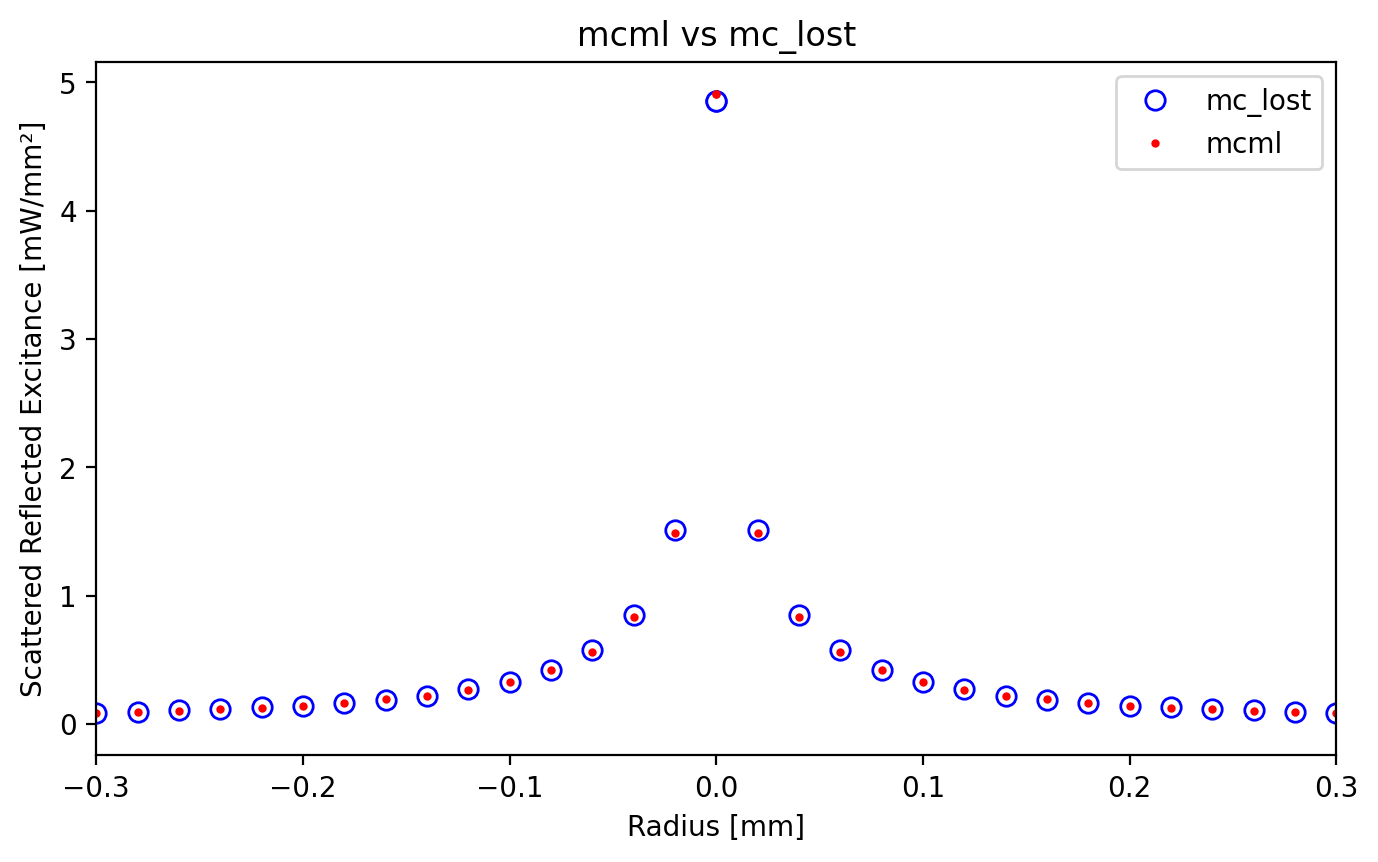

In [18]:
plt.plot(iad_r, iad_rt, 'ob', markersize=7, markerfacecolor='white', markeredgecolor='blue', label='mc_lost')
plt.plot(-iad_r, iad_rt, 'ob', markersize=7, markerfacecolor='white', markeredgecolor='blue')
plt.plot(mcml.r, mcml.Rdr, 'or', markersize=2, label='mcml')
plt.plot(-mcml.r, mcml.Rdr, 'or', markersize=2)
plt.xlabel('Radius [mm]')
plt.ylabel('Scattered Reflected Excitance [mW/mm²]')
plt.title('mcml vs mc_lost')
plt.xlim(-0.3,0.3)
plt.legend()
plt.show()

### Comparing 3mm beams

In [19]:
mus = 0.99  # per mm
mua = 0.01  # per mm
g = 0
n_sample = 1.4
n_slide = 1.0
t_sample = 10
t_slide = 0
a = mus/(mua+mus)
b = (mua+mus)*t_sample
beam_radius = 1.5 # mm

beam_diameter = beam_radius * 2
port_diameter = np.array([4, 6, 10, 15, 20, 30],dtype=float)
iad_r_lost = np.zeros_like(port_diameter)
iad_t_lost = np.zeros_like(port_diameter)

for i, P in enumerate(port_diameter):
    print('running port diameter = %d' % P)
    command = [
        mc_lost_path,
        "-a", str(a),
        "-b", str(b),
        "-B", str(beam_diameter),
        "-n", str(n_sample),
        "-N", str(n_slide),
        "-P", str(P),
        "-t", str(t_sample),
        "-T", str(t_slide),
        "-p", "1000000",
        "-m",
        "-C"
    ]

    result = subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    x = result.stdout.split()
    iad_mc_ur1 = float(x[0])
    iad_mc_ut1 = float(x[1])
    iad_ur1 = float(x[4])
    iad_ut1 = float(x[5])
    iad_r_lost[i] = float(x[8])
    iad_t_lost[i] = float(x[9])

    buffer=StringIO(result.stderr)
    ndr = np.genfromtxt(buffer, max_rows=1)
    dr = np.genfromtxt(buffer, max_rows=1)    
    iad_r_3mm, iad_rt_3mm, iad_tt_3mm = np.genfromtxt(buffer, skip_header=8, max_rows=ndr).T
    buffer.close()

rsp = ((n_sample-1)/(n_sample+1))**2/(np.pi*beam_radius**2)
iad_rd_3mm = iad_rt_3mm
for i, r in enumerate(iad_r_3mm):
    if r<beam_radius:
        iad_rd_3mm[i] -= rsp

running port diameter = 4
running port diameter = 6
running port diameter = 10
running port diameter = 15
running port diameter = 20
running port diameter = 30


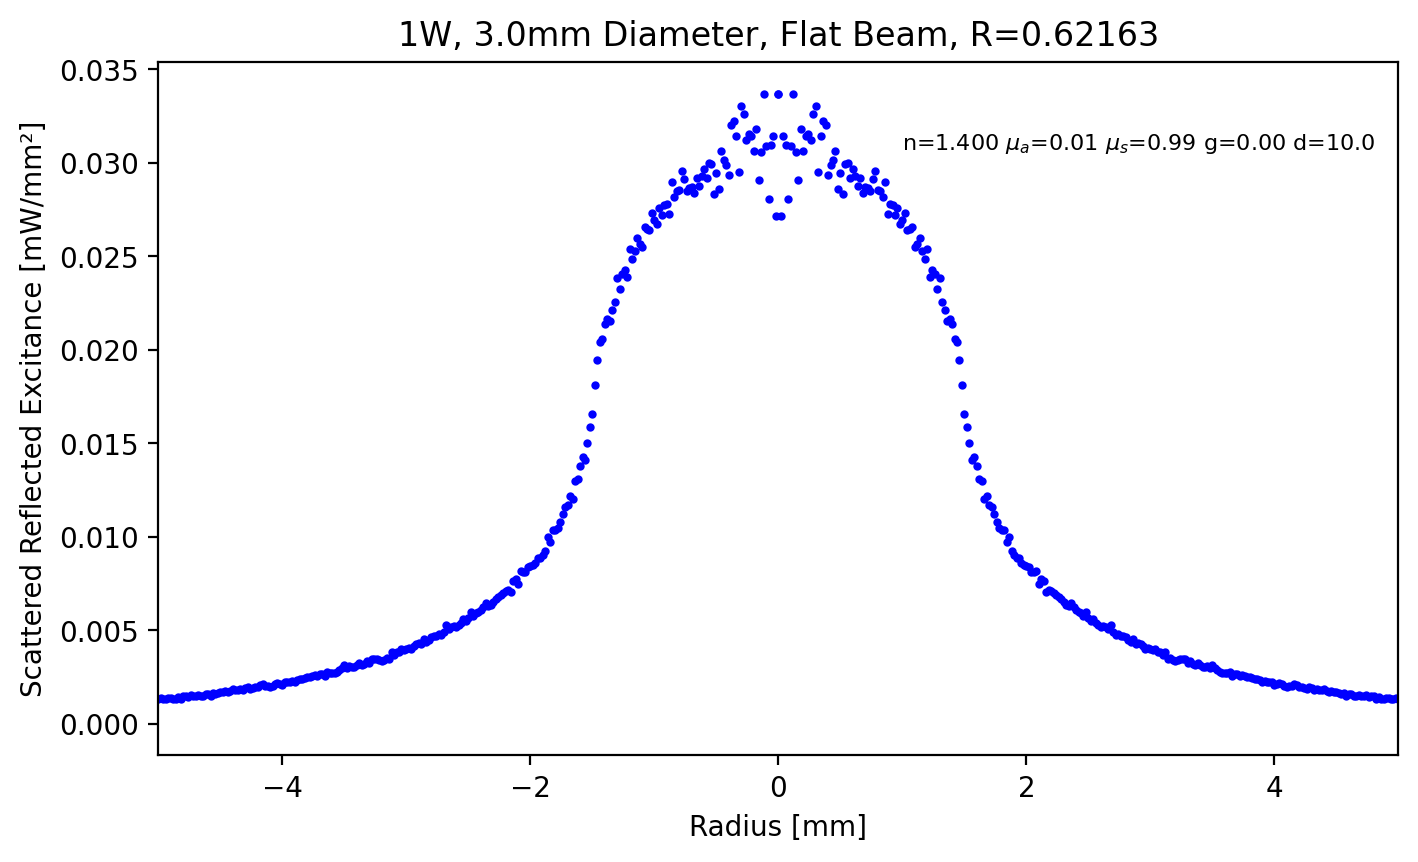

In [20]:
s = ''
s += r'n=%.3f ' % n_sample
s += r'$\mu_a$=%.2f ' % mua
s += r'$\mu_s$=%.2f ' % mus
s += r'g=%.2f ' % g
s += r'd=%.1f' % t_sample

plt.plot(iad_r_3mm, iad_rd_3mm, 'ob', markersize=2)
#plt.plot(iad_r_3mm, rsp, 'ob', markersize=2)
plt.plot(-iad_r_3mm, iad_rd_3mm, 'ob', markersize=2)
plt.xlabel('Radius [mm]')
plt.ylabel('Scattered Reflected Excitance [mW/mm²]')
plt.title('1W, %.1fmm Diameter, Flat Beam, R=%.5f'%(beam_diameter,iad_mc_ur1))
#plt.axvspan(-beam_radius, beam_radius, color='cyan')
plt.xlim(-5,5)

plt.text(0.6, 0.9, s, ha='left', va='top', transform=plt.gca().transAxes, fontsize=8)
plt.show()

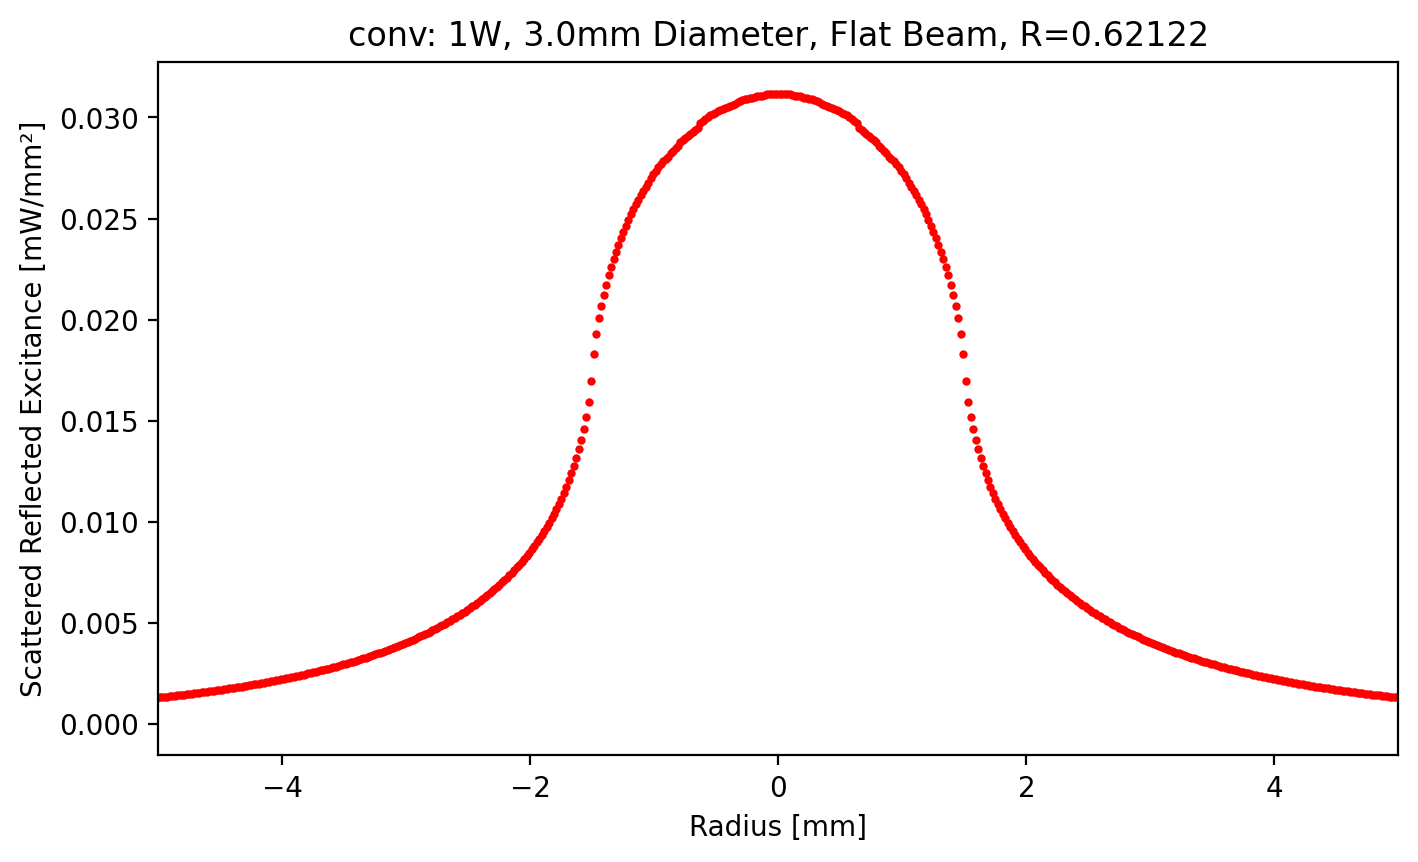

In [21]:
fn = '../tests/mc-lost-v2-2.Rdrc'
mcml_r_3mm, mcml_rd_3mm = np.genfromtxt(fn, skip_header=4).T
mcml_r_3mm *= 10
mcml_rd_3mm /= 100
plt.plot(mcml_r_3mm, mcml_rd_3mm, 'or', markersize=2)
plt.plot(-mcml_r_3mm, mcml_rd_3mm, 'or', markersize=2)

mcml_ur1 = 0.0277778 + 0.593444

plt.xlabel('Radius [mm]')
plt.ylabel('Scattered Reflected Excitance [mW/mm²]')
plt.title('conv: 1W, %.1fmm Diameter, Flat Beam, R=%.5f'%(beam_diameter,mcml_ur1))
#plt.axvspan(-beam_radius, beam_radius, color='cyan')
plt.xlim(-5,5)
plt.show()

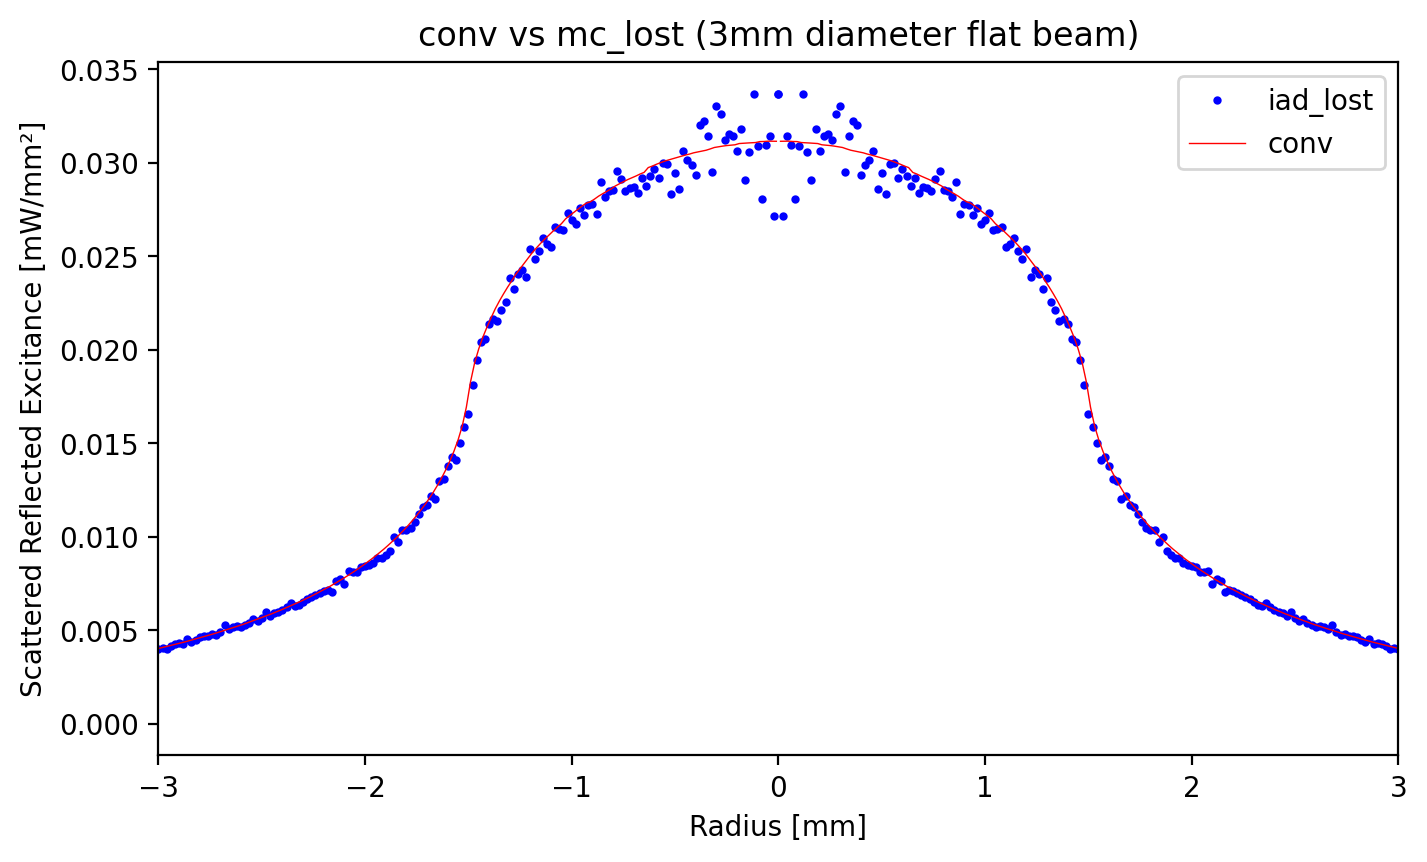

In [22]:
plt.plot(iad_r_3mm, iad_rd_3mm, 'ob', markersize=2, label='iad_lost')
plt.plot(-iad_r_3mm, iad_rd_3mm, 'ob', markersize=2)
plt.plot(mcml_r_3mm, mcml_rd_3mm, 'r', lw=0.5, label='conv')
plt.plot(-mcml_r_3mm, mcml_rd_3mm, 'r', lw=0.5)
plt.xlabel('Radius [mm]')
plt.ylabel('Scattered Reflected Excitance [mW/mm²]')
plt.title('conv vs mc_lost (3mm diameter flat beam)')
plt.xlim(-3,3)
plt.legend()
plt.show()

### Lost light estimates

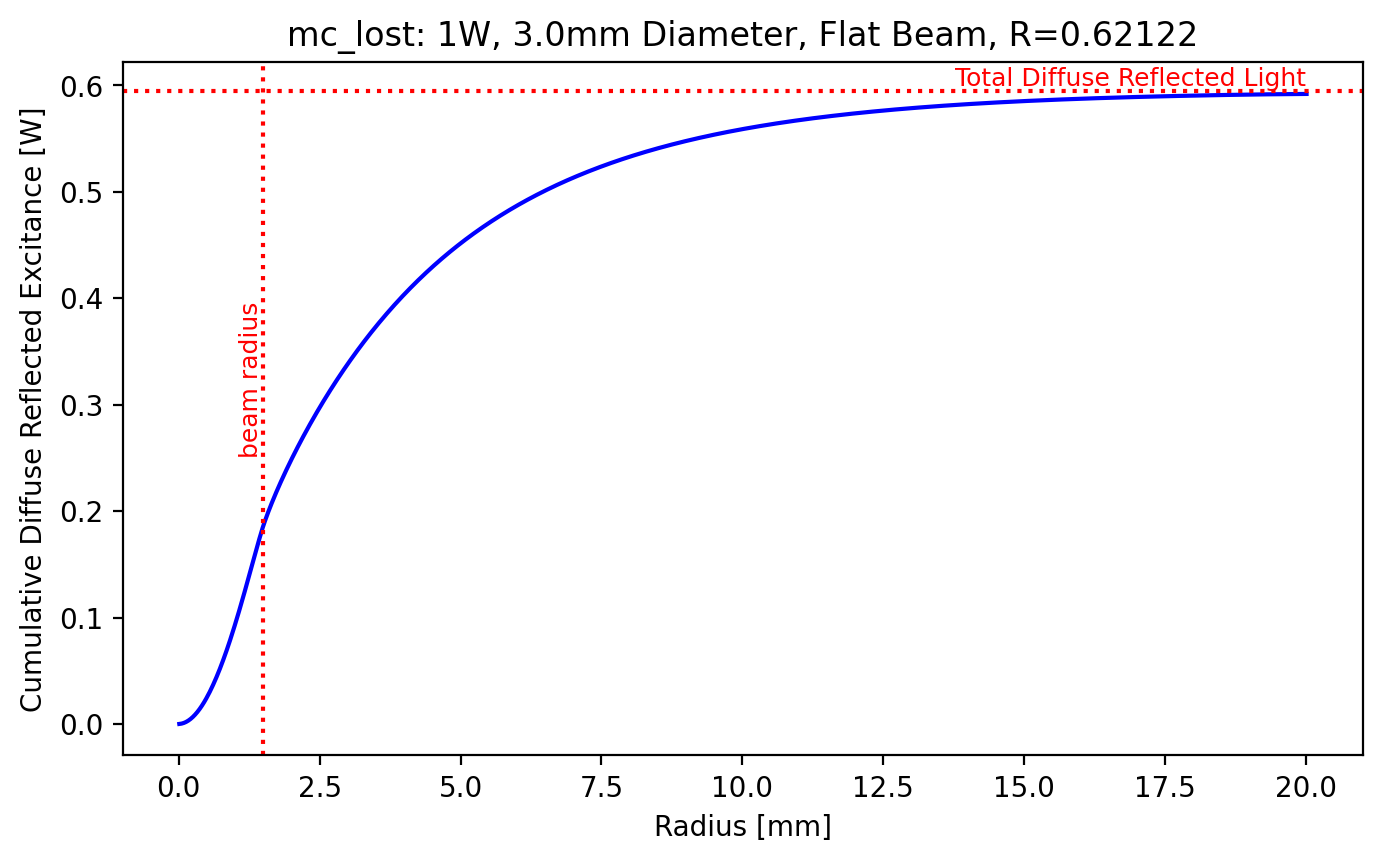

In [23]:
areas = calc_areas(len(mcml_r_3mm), mcml_r_3mm[1]-mcml_r_3mm[0])
mcml_cum = np.cumsum(mcml_rd_3mm*areas)
rsp = ((n_sample-1)/(n_sample+1))**2

plt.figure(figsize=(8,4.5))
plt.plot(mcml_r_3mm, mcml_cum, color='blue')
plt.axhline(iad_ur1-rsp, color='red', linestyle=':')
plt.text(iad_r[-1], iad_ur1-rsp, 'Total Diffuse Reflected Light', ha='right', va='bottom', color='red', fontsize=9)

plt.axvline(beam_radius, color='red', ls=':')
plt.xlabel('Radius [mm]')
plt.text(beam_radius, 0.25, 'beam radius', ha='right', va='bottom', color='red', rotation=90, fontsize=9)

plt.ylabel('Cumulative Diffuse Reflected Excitance [W]')
plt.title('mc_lost: 1W, %.1fmm Diameter, Flat Beam, R=%.5f'%(beam_diameter,mcml_ur1))
plt.show()

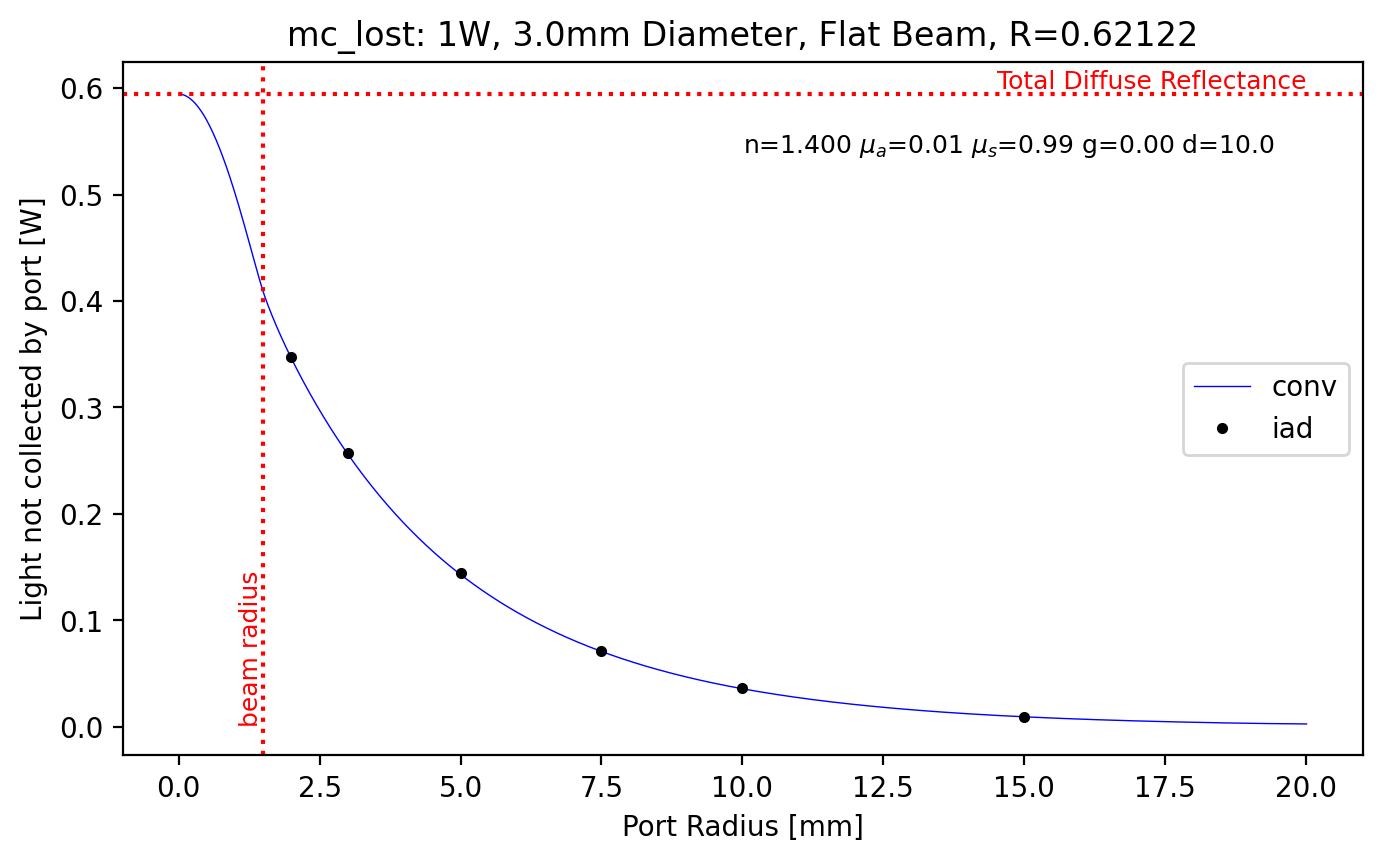

In [24]:

s = ''
s += r'n=%.3f ' % n_sample
s += r'$\mu_a$=%.2f ' % mua
s += r'$\mu_s$=%.2f ' % mus
s += r'g=%.2f ' % g
s += r'd=%.1f' % t_sample

plt.figure(figsize=(8,4.5))
plt.plot(mcml_r_3mm, iad_ur1-rsp-mcml_cum, color='blue', lw=0.5, label='conv')
plt.axhline(iad_ur1-rsp, color='red', ls=':')
plt.text(iad_r[-1], iad_ur1-rsp, 'Total Diffuse Reflectance', ha='right', va='bottom', color='red', fontsize=9)

plt.axvline(beam_radius, color='red', ls=':')
plt.xlabel('Port Radius [mm]')
plt.text(beam_radius, 0, 'beam radius', ha='right', va='bottom', color='red', rotation=90, fontsize=9)

plt.plot(port_diameter/2, iad_r_lost, 'ok', markersize=3, label='iad')
plt.ylabel('Light not collected by port [W]')
plt.title('mc_lost: 1W, %.1fmm Diameter, Flat Beam, R=%.5f'%(beam_diameter,mcml_ur1))
plt.legend()
plt.text(0.5, 0.9, s, ha='left', va='top', transform=plt.gca().transAxes, fontsize=9)
plt.show()

## Sample between glass slides

In [25]:
path = '../tests/mc-lost-v2-3.mco'
mcml = MCMLV2()
mcml.init_from_file(path)
print(mcml)

photons       = 0

R_unscattered =  0.04109
R_scattered   =  0.58166
R_total       =  0.62275
T_unscattered =  0.00004
T_scattered   =  0.10216
T_total       =  0.10220
Absorbed      =  0.27505
Total         =  1.00000

r_bins = 1001, dr = 0.020 mm
z_bins =    1, dz = 0.200 mm
t_bins =    1, dt = 0.100 ps

layer 1: air
    n=1.000 µa=0.00mm⁻¹ µs=0.00mm⁻¹ g=0.00 d=infinite
layer 2: glass
    n=1.500 µa=0.00mm⁻¹ µs=0.00mm⁻¹ g=0.00 d=1.00mm
layer 3: polyurethane
    n=1.400 µa=0.01mm⁻¹ µs=0.99mm⁻¹ g=0.00 d=10.00mm
layer 4: glass
    n=1.500 µa=0.00mm⁻¹ µs=0.00mm⁻¹ g=0.00 d=1.00mm
layer 5: air
    n=1.000 µa=0.00mm⁻¹ µs=0.00mm⁻¹ g=0.00 d=infinite



In [26]:
mus = 0.99  # per mm
mua = 0.01  # per mm
g = 0
n_sample = 1.4
n_slide = 1.5
t_sample = 10
t_slide = 1
a = mus/(mua+mus)
b = (mua+mus)*t_sample
beam_radius = 1.5 # mm

beam_diameter = beam_radius * 2
port_diameter = np.array([4],dtype=float)
iad_r_lost = np.zeros_like(port_diameter)
iad_t_lost = np.zeros_like(port_diameter)

for i, P in enumerate(port_diameter):
    print('running port diameter = %d' % P)
    command = [
        mc_lost_path,
        "-a", str(a),
        "-b", str(b),
        "-B", str(beam_diameter),
        "-n", str(n_sample),
        "-N", str(n_slide),
        "-P", str(P),
        "-t", str(t_sample),
        "-T", str(t_slide),
        "-p", "1000000",
        "-m",
        "-C"
    ]

    result = subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    x = result.stdout.split()
    iad_mc_ur1 = float(x[0])
    iad_mc_ut1 = float(x[1])
    iad_ur1 = float(x[4])
    iad_ut1 = float(x[5])
    iad_r_lost[i] = float(x[8])
    iad_t_lost[i] = float(x[9])

    buffer=StringIO(result.stderr)
    ndr = np.genfromtxt(buffer, max_rows=1)
    dr = np.genfromtxt(buffer, max_rows=1)    
    iad_r_3mm, iad_rt_3mm, iad_tt_3mm = np.genfromtxt(buffer, skip_header=8, max_rows=ndr).T
    buffer.close()

rsp = mcml.Ru/(np.pi*beam_radius**2)
iad_rd_3mm = iad_rt_3mm
for i, r in enumerate(iad_r_3mm):
    if r<beam_radius:
        iad_rd_3mm[i] -= rsp

running port diameter = 4


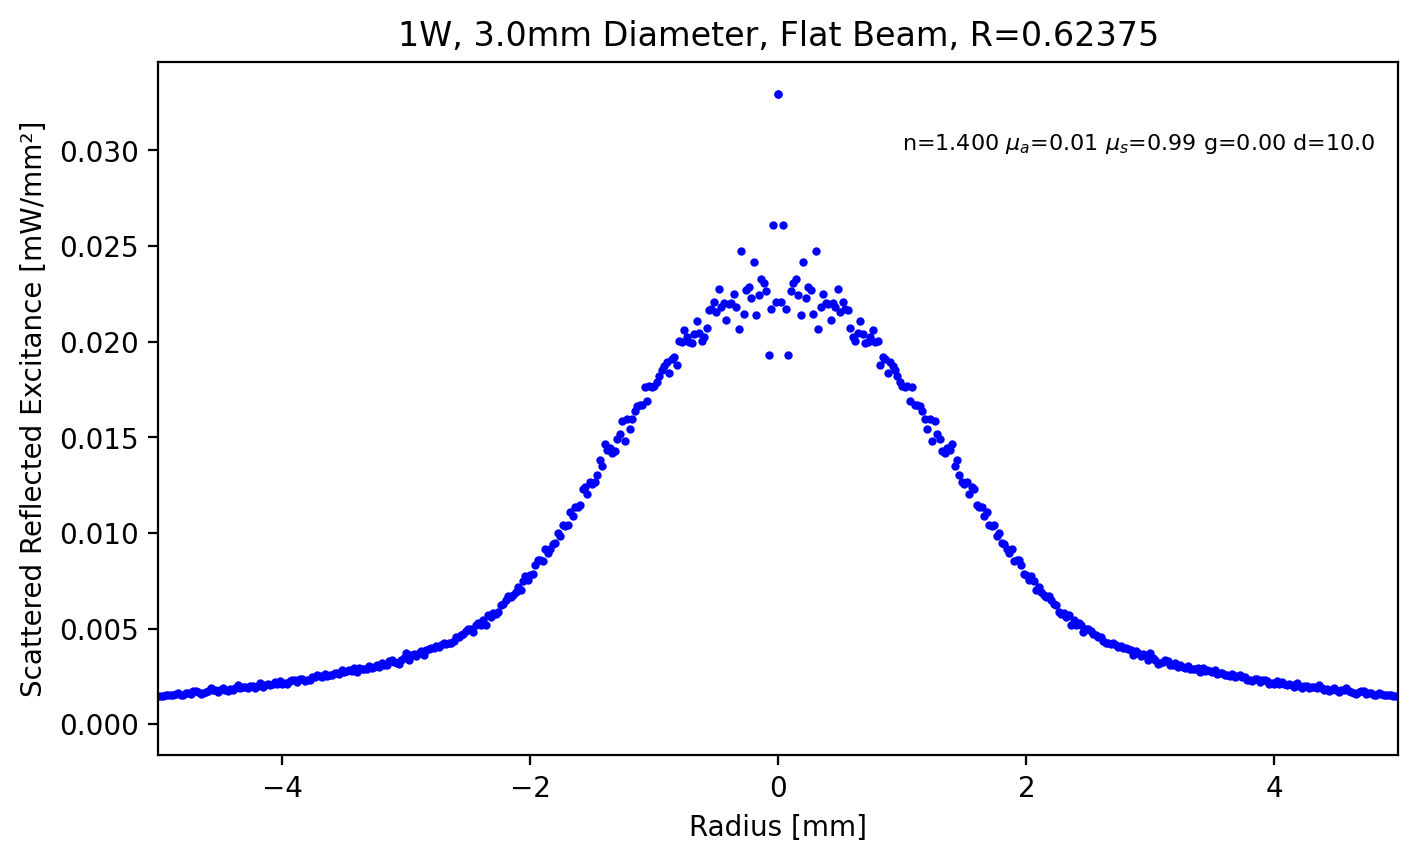

In [27]:
s = ''
s += r'n=%.3f ' % n_sample
s += r'$\mu_a$=%.2f ' % mua
s += r'$\mu_s$=%.2f ' % mus
s += r'g=%.2f ' % g
s += r'd=%.1f' % t_sample

plt.plot(iad_r_3mm, iad_rd_3mm, 'ob', markersize=2)
#plt.plot(iad_r_3mm, rsp, 'ob', markersize=2)
plt.plot(-iad_r_3mm, iad_rd_3mm, 'ob', markersize=2)
plt.xlabel('Radius [mm]')
plt.ylabel('Scattered Reflected Excitance [mW/mm²]')
plt.title('1W, %.1fmm Diameter, Flat Beam, R=%.5f'%(beam_diameter,iad_mc_ur1))
#plt.axvspan(-beam_radius, beam_radius, color='cyan')
plt.xlim(-5,5)

plt.text(0.6, 0.9, s, ha='left', va='top', transform=plt.gca().transAxes, fontsize=8)
plt.show()

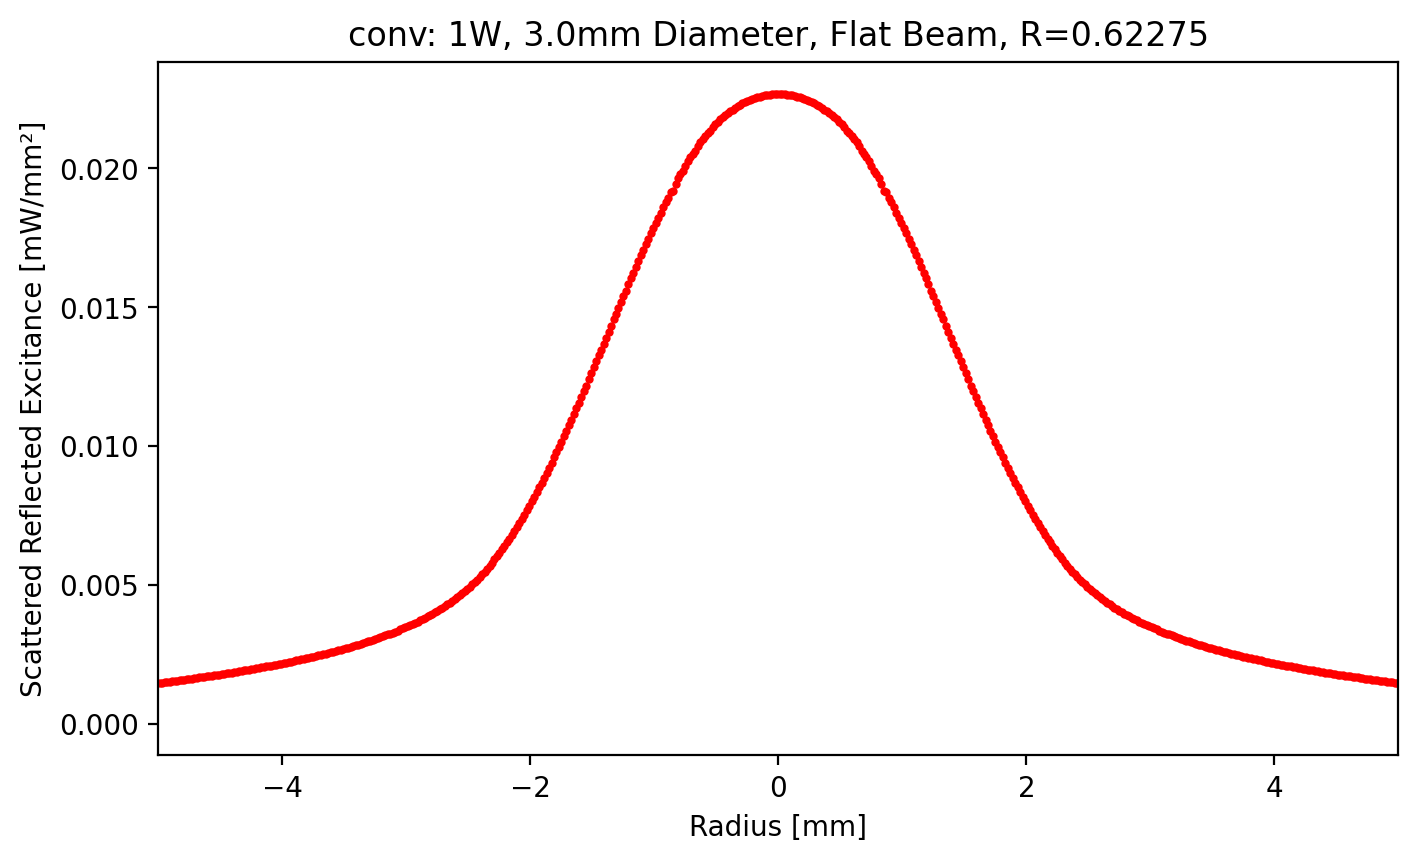

In [28]:
fn = '../tests/mc-lost-v2-3.Rdrc'
mcml_r_3mm, mcml_rd_3mm = np.genfromtxt(fn, skip_header=4).T
mcml_r_3mm *= 10
mcml_rd_3mm /= 100
plt.plot(mcml_r_3mm, mcml_rd_3mm, 'or', markersize=2)
plt.plot(-mcml_r_3mm, mcml_rd_3mm, 'or', markersize=2)

plt.xlabel('Radius [mm]')
plt.ylabel('Scattered Reflected Excitance [mW/mm²]')
plt.title('conv: 1W, %.1fmm Diameter, Flat Beam, R=%.5f'%(beam_diameter,mcml.Rt))
#plt.axvspan(-beam_radius, beam_radius, color='cyan')
plt.xlim(-5,5)
plt.show()

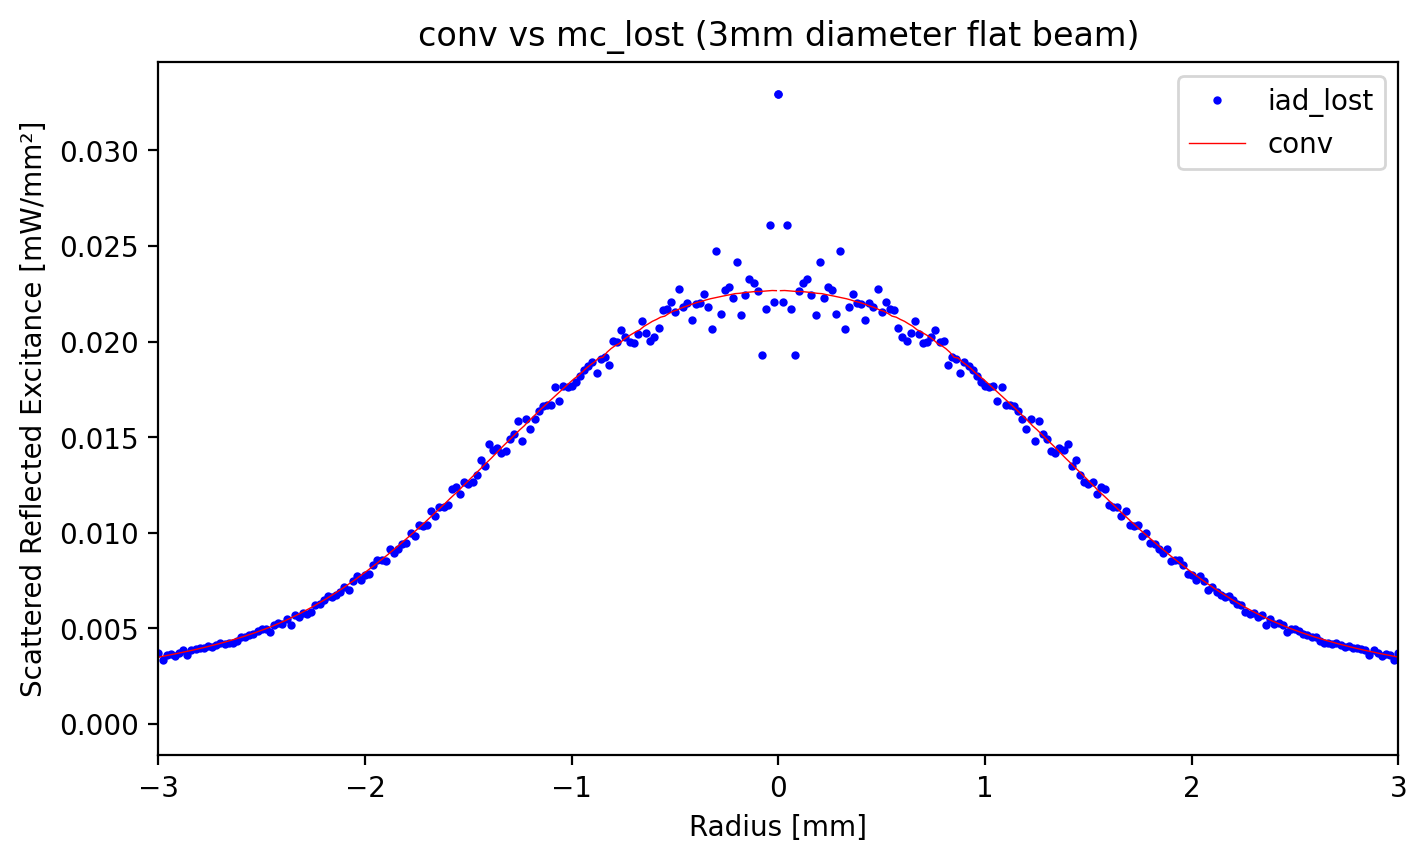

In [29]:
plt.plot(iad_r_3mm, iad_rd_3mm, 'ob', markersize=2, label='iad_lost')
plt.plot(-iad_r_3mm, iad_rd_3mm, 'ob', markersize=2)
plt.plot(mcml_r_3mm, mcml_rd_3mm, 'r', lw=0.5, label='conv')
plt.plot(-mcml_r_3mm, mcml_rd_3mm, 'r', lw=0.5)
plt.xlabel('Radius [mm]')
plt.ylabel('Scattered Reflected Excitance [mW/mm²]')
plt.title('conv vs mc_lost (3mm diameter flat beam)')
plt.xlim(-3,3)
plt.legend()
plt.show()